# Troubleshooting

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 12504846.04it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 192638.48it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3733926.24it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10758483.80it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



In [9]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x



model = FMNIST()

In [6]:
from IPython.core.debugger import set_trace

In [10]:
# here we encountered an issue, import a library in above cell
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        #set_trace() # this will help debugging

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.042534954607614
Training loss: 0.5655411493930735
Training loss: 0.49615861076726586


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0
img = images[test_image_id].view(1, 784)

with torch.no_grad():
    logps = model(img)

In [12]:
ps = torch.exp(logps)
ps

tensor([[2.6060e-06, 1.4587e-06, 6.2960e-05, 4.6188e-05, 4.2507e-05, 1.4646e-01,
         2.0558e-05, 2.1902e-01, 1.4910e-02, 6.1943e-01]])

In [13]:
nps = ps.numpy()[0]
nps

array([2.6059663e-06, 1.4587007e-06, 6.2960309e-05, 4.6188288e-05,
       4.2507127e-05, 1.4646347e-01, 2.0557653e-05, 2.1901950e-01,
       1.4909528e-02, 6.1943126e-01], dtype=float32)

<BarContainer object of 10 artists>

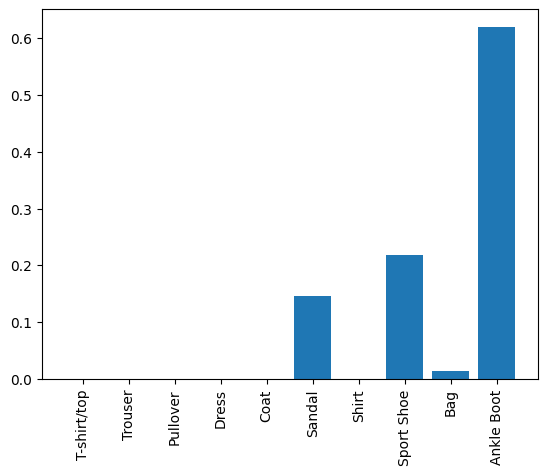

In [14]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoe','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

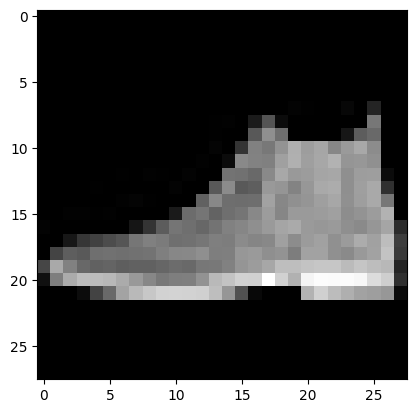

In [15]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor

img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')